# Importing the Data

In [78]:
path = '11th_hour_political_tweets.csv'

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv(path, sep = '|')
include = ['object', 'float', 'int']
columns = ['last_updated', 'tweet_id', 'created_at', 'user_location', 'full_text', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count']
use_data = data[columns]
sem = data[['pos', 'neg']]

In [ ]:
def assign_label(row):
  m = max(row['pos'], row['neg'])
  if m == row['pos']:
    return 1
  return 0

In [ ]:
sem.loc[:,['label']] = sem.apply(lambda row: assign_label(row), axis = 1)
use_data['label'] = sem['label']

<ipython-input-7-8bed54842a7e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sem.loc[:,['label']] = sem.apply(lambda row: assign_label(row), axis = 1)
<ipython-input-7-8bed54842a7e>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sem.loc[:,['label']] = sem.apply(lambda row: assign_label(row), axis = 1)
<ipython-input-7-8bed54842a7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [ ]:
use_data.describe(include = include, datetime_is_numeric = True)

,last_updated,tweet_id,created_at,user_location,full_text,quote_count,reply_count,retweet_count,favorite_count,label
count,46043,4.604100e+04,46041,40264,46041,44641,44633.000000,46036,46043.000000,46043.00000
unique,41640,NaN,45608,6071,45905,486,NaN,3428,NaN,NaN
top,2019-04-20T17:38:25.000+05:30,NaN,0,Others,The RSS &amp; BJP do not allow for dialogue or...,0,NaN,0.0,NaN,NaN
freq,5,NaN,4,10715,16,25713,NaN,5734,NaN,NaN
mean,NaN,1.106724e+18,NaN,NaN,NaN,NaN,32.878319,NaN,440.911691,0.60563
std,NaN,3.553557e+16,NaN,NaN,NaN,NaN,304.689587,NaN,2647.626138,0.48872
min,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.00000
25%,NaN,1.100843e+18,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.00000
50%,NaN,1.107695e+18,NaN,NaN,NaN,NaN,1.000000,NaN,17.000000,1.00000
75%,NaN,1.118480e+18,NaN,NaN,NaN,NaN,7.000000,NaN,131.000000,1.00000


# Data Cleaning & Analysis

## Locations

In [ ]:
loc = pd.DataFrame(use_data['user_location'])
location = loc[loc.user_location != 'Others'].dropna()

In [ ]:
location['user_location'] = location['user_location'].str.rstrip()
location['user_location'] = location['user_location'].astype('str')

In [ ]:
import re
pattern = r'[^\w\s]'
mask = location['user_location'].str.contains(pattern)
location = location.loc[~mask]

location = location.drop(location[mask].index)

<ipython-input-11-a4aec7664970>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  location = location.drop(location[mask].index)


In [ ]:
location['user_location'] = location['user_location'].str.lower()

In [ ]:
import spacy
from spacy import displacy 
from numpy import NaN
nlp = spacy.load('en_core_web_sm')

In [ ]:
for i in location.index:
  if (len(location['user_location'][i].split()) > 1):
    doc = nlp(location['user_location'][i])
    displacy.render(doc, style="ent")
    ch = [ent.text for ent in doc.ents if ent.label_ in ['GPE']]
    if (len(ch) > 0):
      location['user_location'][i] = ch[0]
    else:
      location['user_location'][i] = NaN

/usr/local/lib/python3.10/dist-packages/spacy/displacy/__init__.py:215: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [ ]:
use_data.loc[:, 'user_location'] = location['user_location']

<ipython-input-15-1d1c4e63ae3e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data.loc[:, 'user_location'] = location['user_location']


In [ ]:
un = location['user_location'].dropna()

Text(0, 0.5, 'Number of tweets')

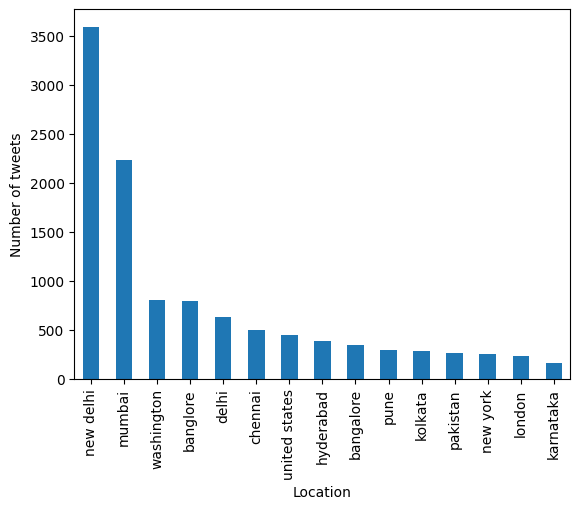

In [ ]:
p = un.value_counts()
dp = p.head(15)
ax = dp.plot(kind = "bar")
ax.set_xlabel('Location')
ax.set_ylabel('Number of tweets')

## Counts


In [ ]:
for i in range(5, 9):
  use_data.loc[:,columns[i]] = pd.to_numeric(use_data[columns[i]], errors='coerce')

<ipython-input-18-1b3c90fc651f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data.loc[:,columns[i]] = pd.to_numeric(use_data[columns[i]], errors='coerce')
<ipython-input-18-1b3c90fc651f>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  use_data.loc[:,columns[i]] = pd.to_numeric(use_data[columns[i]], errors='coerce')


In [ ]:
use_data[columns[-4:]].fillna(0)

,quote_count,reply_count,retweet_count,favorite_count
0,0.0,4.0,113.0,113.0
1,0.0,0.0,5.0,5.0
2,0.0,4.0,31.0,31.0
3,0.0,0.0,3.0,3.0
4,0.0,0.0,9.0,9.0
...,...,...,...,...
46038,0.0,0.0,6.0,6.0
46039,0.0,0.0,2.0,2.0
46040,0.0,1.0,26.0,26.0
46041,0.0,0.0,1.0,1.0


Tweet with maximum Retweets

In [ ]:
print(use_data[use_data['retweet_count'] == use_data['retweet_count'].max()].full_text)

38469    Next time we have a gov shutdown, Congressiona...
Name: full_text, dtype: object


Tweet with minimum Retweets

In [ ]:
print(use_data[use_data['retweet_count'] == use_data['retweet_count'].min()].full_text)

8        PAPPU's lawyer to reply court latest by10.30 a...
11       On this Women's Day, let's look back and see h...
15       @Mayor17Ian @marklevinshow She shouldn’t have ...
45       I strongly condemn Modiji for making unethical...
46       @sumitkashyapjha BJP made @kanhaiyakumar what ...
                               ...                        
45999    TY to the #MovetheMoneyCoalition for your unwa...
46015    @Kanth60581327 Any national or international s...
46025    Amit Shah blames Jawaharlal Nehru, who died in...
46026    @Ishrat Jahan always assists the needy people....
46037    #OppnAbusesChowkidar | SHAMEFUL: National Conf...
Name: full_text, Length: 5734, dtype: object


Tweet with maximum replies

In [ ]:
print(use_data[use_data['reply_count'] == use_data['reply_count'].max()].full_text)

22132    Congress: “We’re going to need a copy of the P...
Name: full_text, dtype: object


Tweet with maximum favorites

In [ ]:
print(use_data[use_data['favorite_count'] == use_data['favorite_count'].max()].full_text)

38469    Next time we have a gov shutdown, Congressiona...
Name: full_text, dtype: object


Influential Locations

In [ ]:
inf_loc = use_data.groupby('user_location')['retweet_count'].sum()

<Axes: xlabel='user_location'>

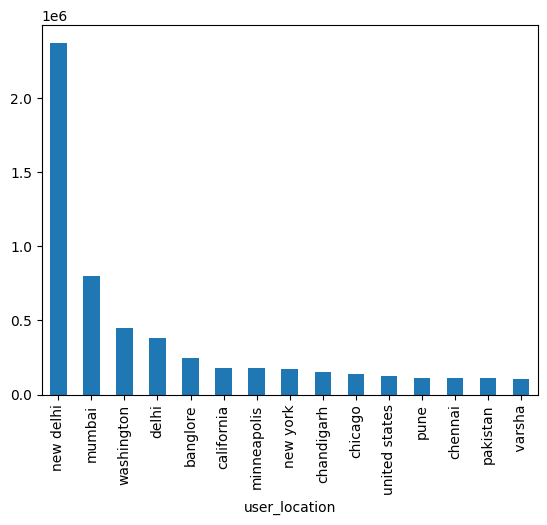

In [ ]:
influent_city = inf_loc.sort_values(ascending = False).head(15)
influent_city.plot(kind = "bar")


Locations where most arguments happen

In [ ]:
rep_loc = use_data.groupby('user_location')['reply_count'].sum()

<Axes: xlabel='user_location'>

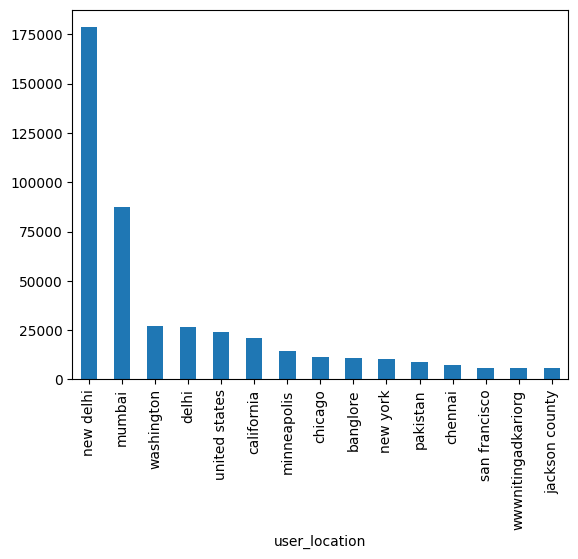

In [ ]:
rep_city = rep_loc.sort_values(ascending = False).head(15)
rep_city.plot(kind = "bar")

Locations where people find support in their ideologies

<Axes: xlabel='user_location'>

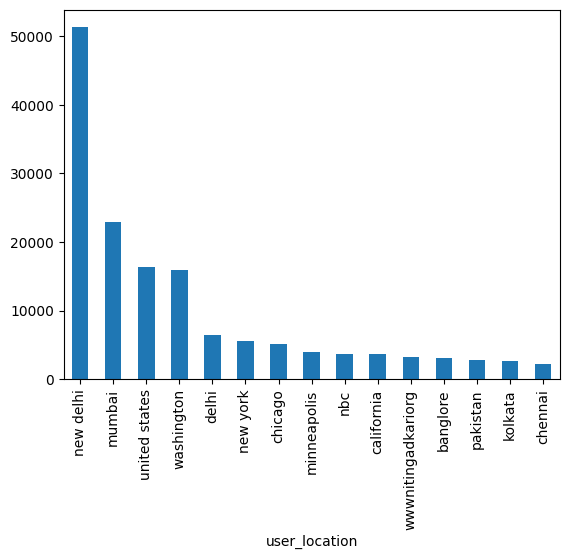

In [ ]:
sup_loc = use_data.groupby('user_location')['quote_count'].sum()
sup_city = sup_loc.sort_values(ascending = False).head(15)
sup_city.plot(kind = "bar")

In [ ]:
data[['subject']].value_counts()

subject           
Bjp                   24293
Congress              19887
Others                 1851
[]                        2
['govt']                  1
['not', 'instead']        1
['now']                   1
dtype: int64

# Text Data

In [ ]:
tweet = use_data[['full_text']].dropna()
tweet.describe()

,full_text
count,46041
unique,45905
top,The RSS &amp; BJP do not allow for dialogue or...
freq,16


In [ ]:
# Removing emojis and emoticons from dataframe
import re
import numpy as np

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

tweet['full_text'] = tweet['full_text'].apply(lambda x: emoji_pattern.sub(r'', x))

In [ ]:
# Removing Links
link_pattern = re.compile(r'http\S+', re.DOTALL)

# Remove links from text column in df
tweet['full_text'] = tweet['full_text'].apply(lambda x: link_pattern.sub('', x))


In [ ]:
# Removing Characters
tweet = tweet.replace(r'[<%@#*\!\n]', '', regex=True)

In [ ]:
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(a):
    s=a["full_text"]
    s = s.lower() #Lowercase the sentence
    s = re.sub(r"\'t", " not", s) # Change 't to 'not'
    s = re.sub(r'(@.*?)[\s]', ' ', s)   # Remove @name
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s) # Isolate and remove punctuations except '?'
    s = re.sub(r'[^\w\s\?]', ' ', s)
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)  # Remove some special characters
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    s = re.sub(r'\s+', ' ', s).strip() # Remove trailing whitespace
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tweet.loc[:,["processed"]]=tweet.apply(lambda row: text_preprocessing(row), axis=1)

In [ ]:
party = []
for i in tweet.index:
  st = tweet['full_text'][i]
  if st.find("BJP") == -1 and st.find("Modi") == -1 and st.find("bjp") == -1 and st.find("modi") == -1 and st.find("narendramodi") == -1:
    party.append(np.nan)
  else:
    party.append("BJP")

In [ ]:
tweet['party1'] = party

In [ ]:
tweet['party1'].value_counts()

BJP    25682
Name: party1, dtype: int64

In [ ]:
party = []
for i in tweet.index:
  st = tweet['full_text'][i]
  if st.find("INC") == -1 and st.find("Congress") == -1 and st.find("cong") == -1 and st.find("Gandhi") == -1 and st.find("Rahul") == -1:
    party.append(np.nan)
  else:
    party.append("INC")

In [ ]:
tweet['party2'] = party

In [ ]:
tweet['party2'].value_counts()

INC    22609
Name: party2, dtype: int64

In [ ]:
col = ['party1', 'party2']
k = tweet.groupby(col).count()

In [ ]:
tweet.describe()

,full_text,processed,party1,party2
count,46041,46041,25682,22609
unique,45691,45532,1,1
top,The RSS &amp; BJP do not allow for dialogue or...,rss amp bjp not allow dialogue debate opinion ...,BJP,INC
freq,16,17,25682,22609


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords

final_stopwords_list = stopwords.words('english') + ['Shri' ,'shri' ,'ji']
# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(  
    min_df = 5,
    max_df = 0.95,
    max_features = 10000,
    stop_words = final_stopwords_list)
X = vectorizer.fit_transform(tweet['full_text'])

In [ ]:
use_data.head()

,last_updated,tweet_id,created_at,user_location,full_text,quote_count,reply_count,retweet_count,favorite_count,label
0,2019-03-06T17:30:21.000+05:30,1.103136e+18,2019-03-06T03:33:25.000+05:30,guwahati,Guwahati has gained a lot of prominence in rec...,0.0,4.0,113.0,113.0,1
1,2019-03-17T18:11:58.000+05:30,1.107333e+18,2019-03-17T17:27:57.000+05:30,NaN,RSS in school days itself? Indoctrinated since...,0.0,0.0,5.0,5.0,0
2,2019-03-23T18:07:38.000+05:30,1.109417e+18,2019-03-23T11:28:31.000+05:30,new delhi,Words don't exist in Vaccum!\nModi's post Pulw...,0.0,4.0,31.0,31.0,0
3,2019-03-11T17:47:32.000+05:30,1.100300e+18,2019-02-26T07:40:28.000+05:30,NaN,"India's #Icecream Industry stands at 15,000 cr...",0.0,0.0,3.0,3.0,1
4,2019-02-27T18:18:42.000+05:30,1.100733e+18,2019-02-27T12:21:18.000+05:30,NaN,*40 CRPF Jawans killed in Pulwama Attack\n*IAF...,0.0,0.0,9.0,9.0,0


In [ ]:
new_data = pd.DataFrame({'full_text': tweet['processed'],'label': use_data['label']})

In [ ]:
new_data = new_data.dropna(subset=['full_text'])

In [ ]:
null_label_rows = new_data[new_data['label'].isna()]

In [ ]:
new_data = new_data.dropna(subset=['label'])

Split the entire training data into two sets: 

In [ ]:
from sklearn.model_selection import train_test_split

X1 = new_data.full_text.values
Y = new_data.label.values

X_train, X_val, Y_train, Y_val =train_test_split(X1, Y, test_size=0.4, random_state=42)

In [ ]:
Z1=null_label_rows.full_text.values
Z2=null_label_rows.label.values
Z1
Z2

array([], dtype=int64)

Set up GPU

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


PreProcessing

TF-IDF Vectorizer to vectorize our text data before feeding them to machine learning algorithms.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

final_stopwords_list = stopwords.words('english') + ['Shri' ,'shri' ,'ji']
# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(  
    min_df = 5,
    max_df = 0.95,
    max_features = 1000,
    stop_words = final_stopwords_list)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.fit_transform(X_val)

Train Naive Bayes Classifier

Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, Y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  1.9


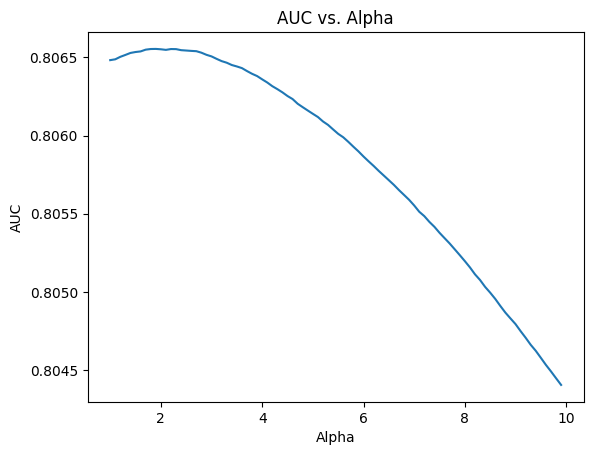

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot as plt

res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

Evaluation on Validation Set

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.5835
Accuracy: 61.26%


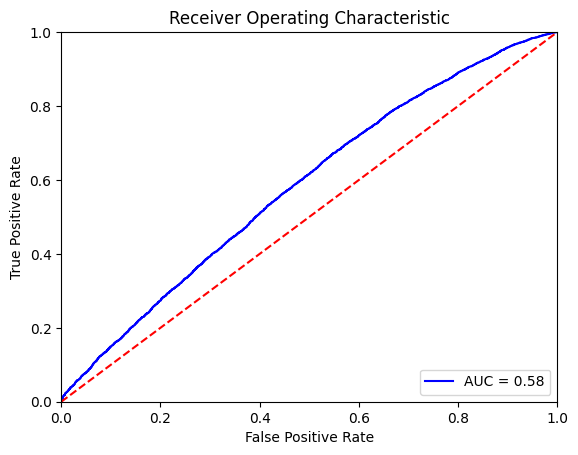

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.9)
nb_model.fit(X_train_tfidf, Y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, Y_val)

## Clustering Text data

In [ ]:
X1_tfidf = vectorizer.fit_transform(X1)

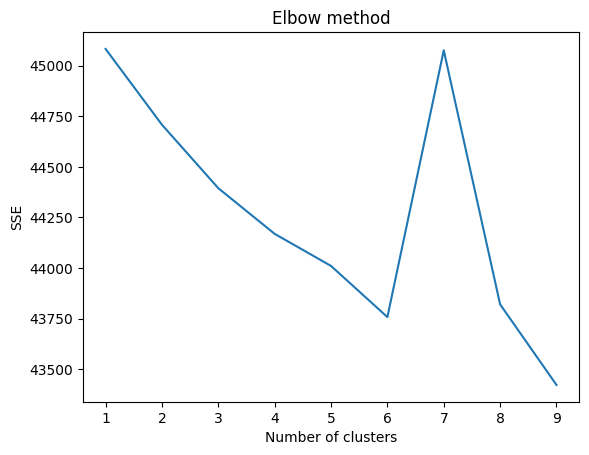

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# Create a list to store the SSE values for different k
sse = []

# Define the range of k values to try
k_range = range(1, 10)

# Iterate over different k values and calculate SSE
for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, n_init = k, init_size=1024, batch_size=2048, random_state=20).fit(X1_tfidf)
    sse.append(kmeans.inertia_)

# Plot the SSE values against k
plt.plot(k_range, sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow method')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Cluster text data using K-Means
k = 4 # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, max_iter = 1000, init = 'k-means++', n_init = 10)
y_pred = kmeans.fit_predict(X1_tfidf)

tweet['cluster'] = y_pred

In [ ]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(X1_tfidf, y_pred, vectorizer.get_feature_names_out(), 10)


Cluster 0
narendramodi,people,indian,pakistan,govt,narendra,amp,india,pm,modi

Cluster 1
chowkidar,rahulgandhi,aap,vote,bjp4india,incindia,india,amp,narendramodi,bjp

Cluster 2
priyanka,mahatma,pm,indira,india,amp,sonia,rajiv,rahul,gandhi

Cluster 3
like,one,get,members,us,people,party,president,amp,congress


In [ ]:
def assign_party(row):
  c = row['cluster']
  if c == 0 or c== 1:
    return 'BJP'
  else:
    return 'INC'

In [ ]:
tweet.loc[:,['party']] = tweet.apply(lambda row: assign_party(row), axis = 1)

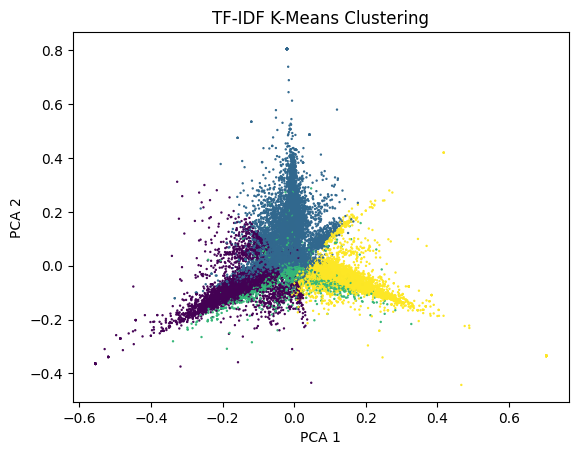

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensions of the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X1_tfidf.toarray())

# Plot the data with different colors for each cluster
plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 0.5,c=kmeans.labels_)
plt.title('TF-IDF K-Means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


The Distribution of tweets for BJP and Congress

In [ ]:
pdata = tweet.groupby('party').count()[['full_text']]

In [ ]:
pdata

,full_text
party,
BJP,28883
INC,17158


Text(0, 0.5, 'TWEETS')

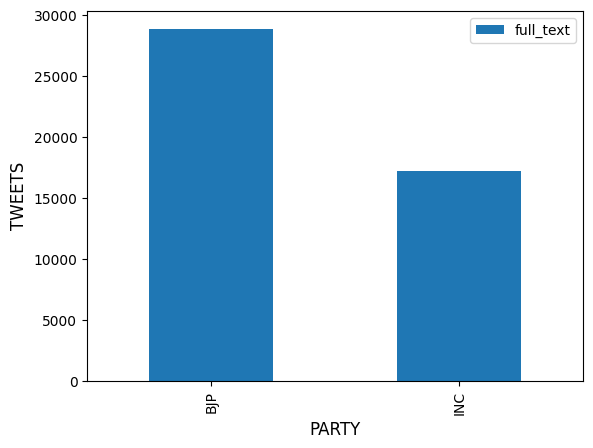

In [ ]:

ax = pdata.plot(kind='bar')

# Use a consistent color scheme
colors = ['#8B008B', '#9932CC', '#BA55D3', '#FF00FF']
ax.set_prop_cycle('color', colors)

# Label your axes
ax.set_xlabel('PARTY', fontsize=12)
ax.set_ylabel('TWEETS', fontsize=12)



In [ ]:
tweet['label'] = use_data['label']

In [ ]:
p1data = tweet.groupby(['party', 'label']).count()[['full_text']]

In [ ]:
p1data

full_text
party label           
BJP   0          11262
      1          17621
INC   0           6894
      1          10264

In [ ]:
p1data[:2]

full_text
party label           
BJP   0          11262
      1          17621

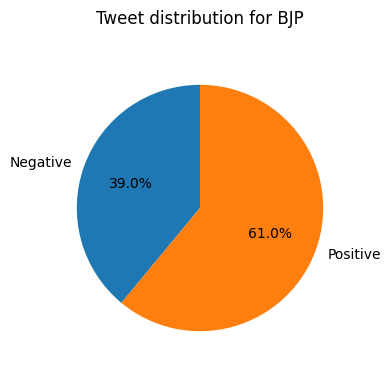

In [ ]:
# Create a pie chart
ax = p1data[:2].plot(kind='pie', y='full_text', labels = ['Negative', 'Positive'], autopct='%1.1f%%', startangle=90, shadow=False, legend=False)

# Add a title and subtitle
ax.text(x=0.5, y=1.1, s='Tweet distribution for BJP', fontsize=12, ha='center', transform=ax.transAxes)
ax.set_ylabel('')
# Increase chart size
plt.gcf().set_size_inches(4, 4)

# Show the chart
plt.show()

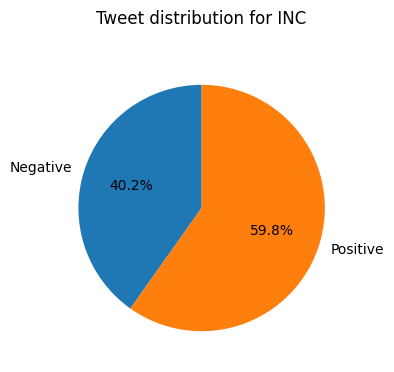

In [ ]:
# Create a pie chart
ax = p1data[2:].plot(kind='pie', y='full_text', labels = ['Negative', 'Positive'], autopct='%1.1f%%', startangle=90, shadow=False, legend=False)

# Add a title and subtitle
ax.text(x=0.5, y=1.1, s='Tweet distribution for INC', fontsize=12, ha='center', transform=ax.transAxes)
ax.set_ylabel('')
# Increase chart size
plt.gcf().set_size_inches(4, 4)

# Show the chart
plt.show()

Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X1_tfidf)


LatentDirichletAllocation(n_components=5, random_state=42)

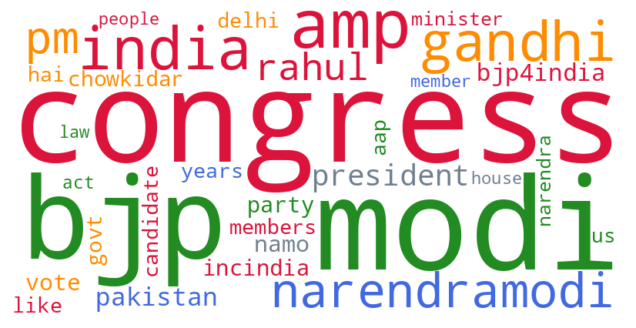

In [ ]:
# Extract top words for each topic and their probabilities
feature_names = np.array(vectorizer.get_feature_names_out())
topics = lda.components_

word_freq_dict = {}
colors = ['#4169E1', '#DC143C', '#228B22', '#FF8C00', '#708090']

for topic_idx, topic in enumerate(topics):
    top_words_idx = topic.argsort()[:-11:-1]
    top_words = feature_names[top_words_idx]
    top_word_freqs = topic[top_words_idx]
    for word, freq in zip(top_words, top_word_freqs):
        if word in word_freq_dict:
            word_freq_dict[word] += freq
        else:
            word_freq_dict[word] = freq

# Define a function that maps each word to a color
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return colors[np.random.randint(len(colors))]

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(word_freq_dict)

# Plot the wordcloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

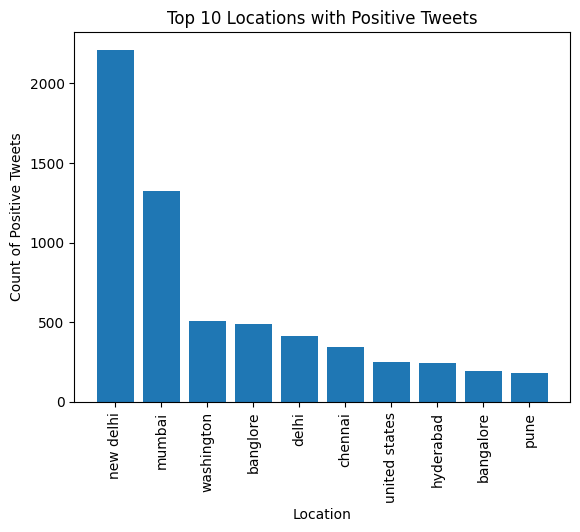

In [ ]:
# Filter the dataset to only include positive sentiment labels
data_pos = use_data[use_data['label'] == 1]

# Count the number of positive tweets for each location
loc_counts = data_pos['user_location'].value_counts()

# Sort the locations by the count of positive tweets in descending order
loc_counts = loc_counts.sort_values(ascending=False)

# Select the top 10 locations with the highest counts
top_locs = loc_counts[:10]

# Create a bar plot
plt.bar(top_locs.index, top_locs.values)
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Count of Positive Tweets')
plt.title('Top 10 Locations with Positive Tweets')
plt.show()

In [ ]:
use_data['party']=tweet['party']

<ipython-input-81-a7ad42805987>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['party']=tweet['party']


In [ ]:
# # Filter the positive tweets
# positive_tweets = use_data[use_data['label'] == 1]

# # Group the positive tweets by location and party
# positive_tweets_grouped = positive_tweets.groupby(['user_location', 'party']).size().reset_index(name='count')

# # Find the top 5 locations by the number of positive tweets
# top_locations = positive_tweets_grouped.groupby('user_location').sum().sort_values(by='count', ascending=False).head(5).index

# # Plot the bar chart for each location
# for location in top_locations:
#     location_data = positive_tweets_grouped[positive_tweets_grouped['user_location'] == location]
#     plt.bar(location_data['party'], location_data['count'])
#     plt.title("Positive tweets for {location}")
#     plt.xlabel("Party")
#     plt.ylabel("Number of positive tweets")
#     plt.show()

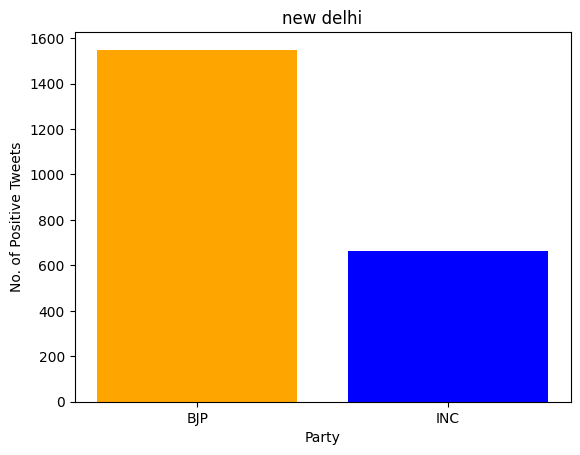

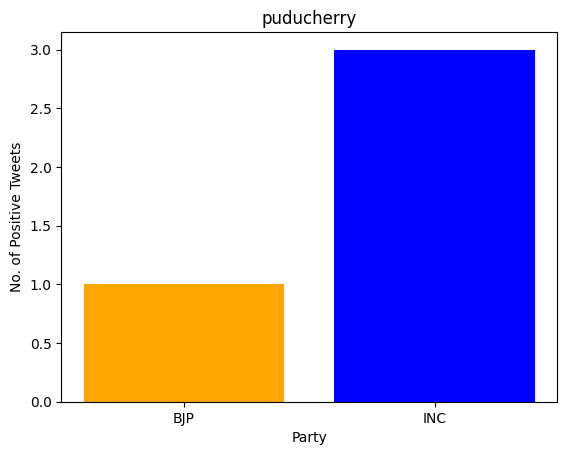

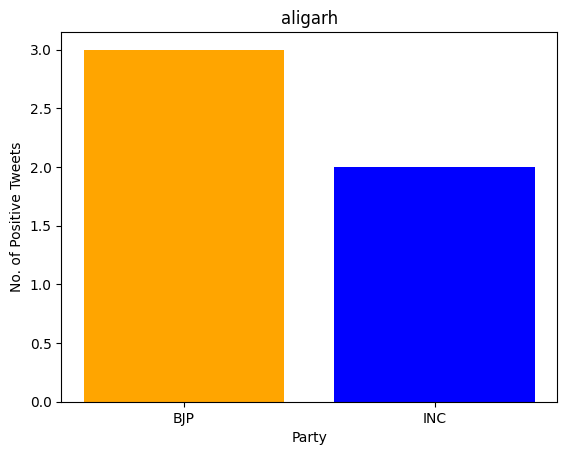

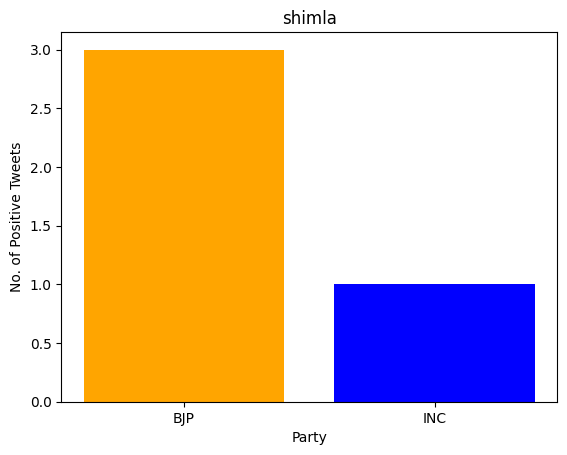

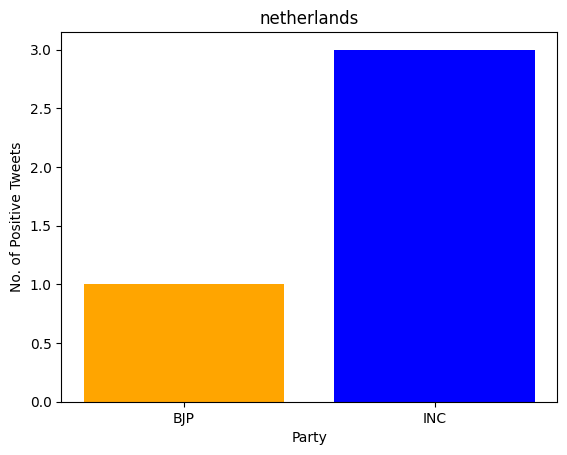

In [ ]:

# filter the data for positive tweets only
positive_data = use_data[use_data['label'] == 1]

# group the data by location and party
grouped_data = positive_data.groupby(['user_location', 'party']).size().reset_index(name='count')

# sort the data by count in descending order
sorted_data = grouped_data.sort_values(by=['count'], ascending=False)

# select top 5 locations
top_5_locations = sorted_data['user_location'].value_counts().nlargest(5).index

# create a list of party colors
colors = {'BJP': 'orange', 'INC': 'blue'}

# Plot the grouped bar chart
ax = grouped_data.plot(kind='bar', stacked=False, width=0.4)

# Set the axis labels and title
ax.set_xlabel('Location')
ax.set_ylabel('Number of Positive Tweets')
ax.set_title('Number of Positive Tweets by Party in Top 5 Locations')

# Add legend and adjust layout
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-93-a0372ddf2256>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_5_locations)


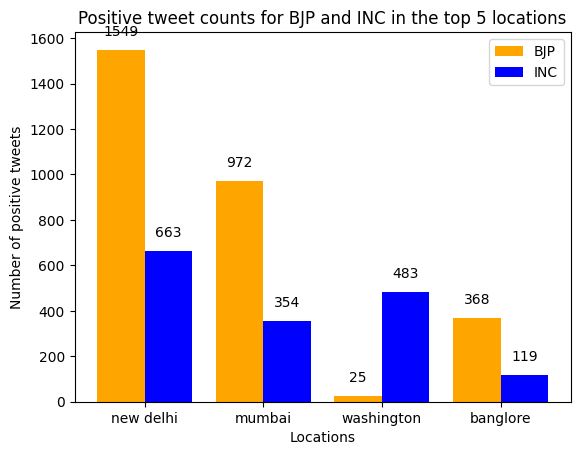

In [ ]:

# Get the top 5 locations with maximum positive tweets
top_5_locations = use_data[use_data['label'] == 1]['user_location'].value_counts().nlargest(4).index.tolist()

# Initialize empty dictionaries to store positive tweet counts for each party in each location
bjp_counts = {}
inc_counts = {}

# Iterate over the top 5 locations and calculate positive tweet counts for each party
for location in top_5_locations:
    bjp_counts[location] = use_data[(use_data['user_location'] == location) & (use_data['label'] == 1) & (use_data['party'] == 'BJP')].shape[0]
    inc_counts[location] = use_data[(use_data['user_location'] == location) & (use_data['label'] == 1) & (use_data['party'] == 'INC')].shape[0]

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis and y-axis labels
ax.set_xlabel('Locations')
ax.set_ylabel('Number of positive tweets')

# Set the x-axis tick labels to the top 5 locations
ax.set_xticklabels(top_5_locations)

# Set the x-axis tick positions
ax.set_xticks(range(len(top_5_locations)))

# Plot the bar for BJP positive tweet counts for each location
ax.bar([i-0.2 for i in range(len(top_5_locations))], bjp_counts.values(), width=0.4, label='BJP', color='orange')

# Plot the bar for INC positive tweet counts for each location
ax.bar([i+0.2 for i in range(len(top_5_locations))], inc_counts.values(), width=0.4, label='INC', color='blue')

# Add labels for the bars
for i in range(len(top_5_locations)):
    ax.text(i-0.2, bjp_counts[top_5_locations[i]]+50, bjp_counts[top_5_locations[i]], ha='center', va='bottom')
    ax.text(i+0.2, inc_counts[top_5_locations[i]]+50, inc_counts[top_5_locations[i]], ha='center', va='bottom')

# Add a title to the plot
ax.set_title('Positive tweet counts for BJP and INC in the top 5 locations')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()
# This code will plot a single bar chart for the top 5 locations with two bars for each party indicating the number of positive tweets in that location. The x-axis will have the top 5 locations and the y-axis will have the number of positive tweets. The BJP bar will be





<ipython-input-96-664fb1a35b04>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_5_locations)


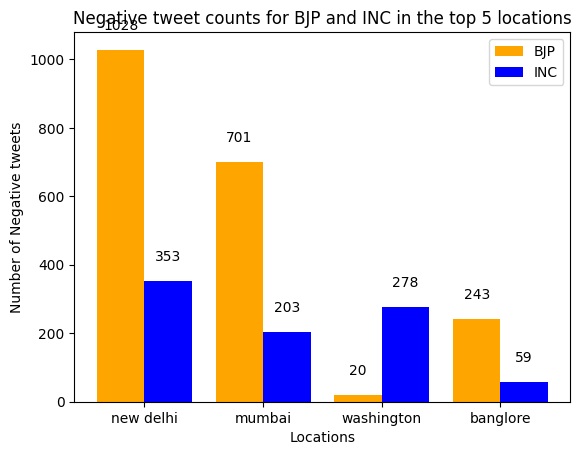

In [ ]:
# Initialize empty dictionaries to store positive tweet counts for each party in each location
bjp_counts = {}
inc_counts = {}

# Iterate over the top 5 locations and calculate positive tweet counts for each party
for location in top_5_locations:
    bjp_counts[location] = use_data[(use_data['user_location'] == location) & (use_data['label'] == 0) & (use_data['party'] == 'BJP')].shape[0]
    inc_counts[location] = use_data[(use_data['user_location'] == location) & (use_data['label'] == 0) & (use_data['party'] == 'INC')].shape[0]

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis and y-axis labels
ax.set_xlabel('Locations')
ax.set_ylabel('Number of Negative tweets')

# Set the x-axis tick labels to the top 5 locations
ax.set_xticklabels(top_5_locations)

# Set the x-axis tick positions
ax.set_xticks(range(len(top_5_locations)))

# Plot the bar for BJP positive tweet counts for each location
ax.bar([i-0.2 for i in range(len(top_5_locations))], bjp_counts.values(), width=0.4, label='BJP', color='orange')

# Plot the bar for INC positive tweet counts for each location
ax.bar([i+0.2 for i in range(len(top_5_locations))], inc_counts.values(), width=0.4, label='INC', color='blue')

# Add labels for the bars
for i in range(len(top_5_locations)):
    ax.text(i-0.2, bjp_counts[top_5_locations[i]]+50, bjp_counts[top_5_locations[i]], ha='center', va='bottom')
    ax.text(i+0.2, inc_counts[top_5_locations[i]]+50, inc_counts[top_5_locations[i]], ha='center', va='bottom')

# Add a title to the plot
ax.set_title('Negative tweet counts for BJP and INC in the top 5 locations')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()
# This code will plot a single bar chart for the top 5 locations with two bars for each party indicating the number of positive tweets in that location. The x-axis will have the top 5 locations and the y-axis will have the number of positive tweets. The BJP bar will be





<ipython-input-90-b96c65c08fae>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_5_locations)


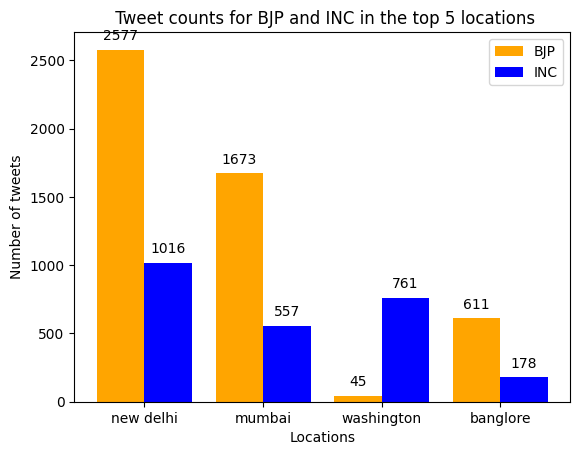

In [ ]:
# Initialize empty dictionaries to store positive tweet counts for each party in each location
bjp_counts = {}
inc_counts = {}

# Iterate over the top 5 locations and calculate positive tweet counts for each party
for location in top_5_locations:
    bjp_counts[location] = use_data[(use_data['user_location'] == location)  & (use_data['party'] == 'BJP')].shape[0]
    inc_counts[location] = use_data[(use_data['user_location'] == location) & (use_data['party'] == 'INC')].shape[0]

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis and y-axis labels
ax.set_xlabel('Locations')
ax.set_ylabel('Number of tweets')

# Set the x-axis tick labels to the top 5 locations
ax.set_xticklabels(top_5_locations)

# Set the x-axis tick positions
ax.set_xticks(range(len(top_5_locations)))

# Plot the bar for BJP positive tweet counts for each location
ax.bar([i-0.2 for i in range(len(top_5_locations))], bjp_counts.values(), width=0.4, label='BJP', color='orange')

# Plot the bar for INC positive tweet counts for each location
ax.bar([i+0.2 for i in range(len(top_5_locations))], inc_counts.values(), width=0.4, label='INC', color='blue')

# Add labels for the bars
for i in range(len(top_5_locations)):
    ax.text(i-0.2, bjp_counts[top_5_locations[i]]+50, bjp_counts[top_5_locations[i]], ha='center', va='bottom')
    ax.text(i+0.2, inc_counts[top_5_locations[i]]+50, inc_counts[top_5_locations[i]], ha='center', va='bottom')

# Add a title to the plot
ax.set_title(' Tweet counts for BJP and INC in the top 5 locations')

# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()
# This code will plot a single bar chart for the top 5 locations with two bars for each party indicating the number of positive tweets in that location. The x-axis will have the top 5 locations and the y-axis will have the number of positive tweets. The BJP bar will be



